In [1]:
from fytok.Tokamak import Tokamak

2023-11-20 15:02:55,443 [   fytok]     INFO: 
#######################################################################################################################
    ______      _____     _
   / ____/_  __|_   _|__ | | __
  / /_  / / / /  | |/ _ \| |/ /
 / __/ / /_/ /   | | (_) |   <
/_/    \__, /    |_|\___/|_|\_\
      /____/

 Copyright (c) 2021-present Zhi YU (Institute of Plasma Physics Chinese Academy of Sciences)
            
 url: https://gitee.com/openfusion/fytok_tutorial 
      https://github.com/fusion-yun/fytok_tutorial

 version = develop  (spdm=develop extension=0.2.2.dev11+g706f667, imas_version=v3_38_1_dirty)

 Run by salmon at 2023-11-20T15:02:55.443667.
 Job ID: fytok_salmon_surface_7752

#######################################################################################################################



In [2]:
tok = Tokamak("mdsplus:///home/salmon/workspace/fytok_data/mdsplus/~t/?enable=efit_east", device="east", shot=70754)

2023-11-20 15:02:55,574 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.plugins.data.plugin_xml


In [3]:
tok.refresh(time=5.0)

2023-11-20 15:02:56,074 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module fytok.plugins.equilibrium.fy_eq
2023-11-20 15:02:56,182 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.plugins.data.plugin_mdsplus
2023-11-20 15:02:56,185 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/plugins/data/plugin_mdsplus.py:118:get_tree: Open MDSplus Tree [efit_east] shot=70754
2023-11-20 15:02:56,235 [   fytok]    DEBUG: /home/salmon/workspace/fytok/python/fytok/modules/Utilities.py:114:execute: Execute fytok.plugins.equilibrium.fy_eq-0.0.1 [Zhi YU@ASIPP]


RuntimeError: <Tokamak />

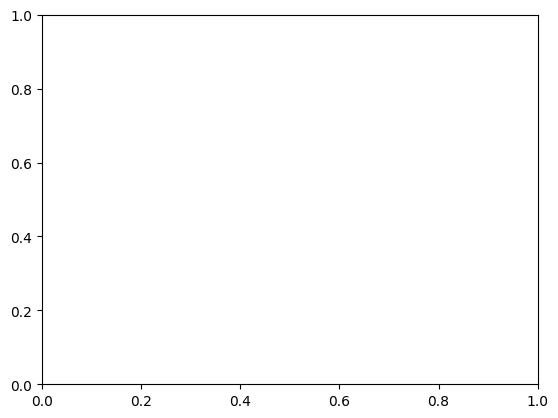

In [12]:
display(tok)

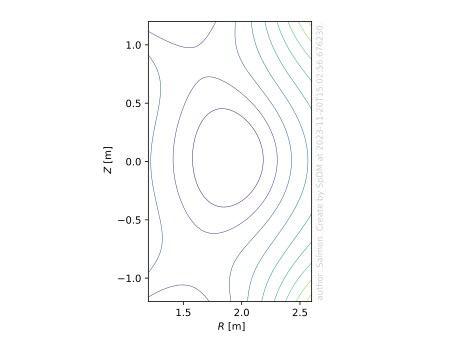

In [5]:
tok.equilibrium.time_slice.current.profiles_2d.psi

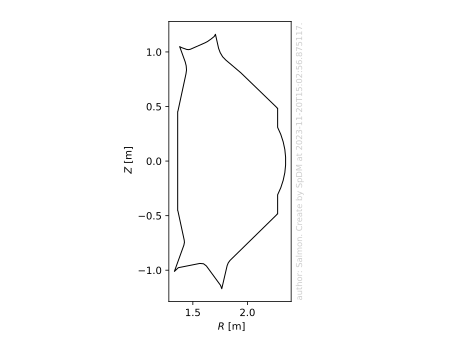

In [6]:
tok.wall

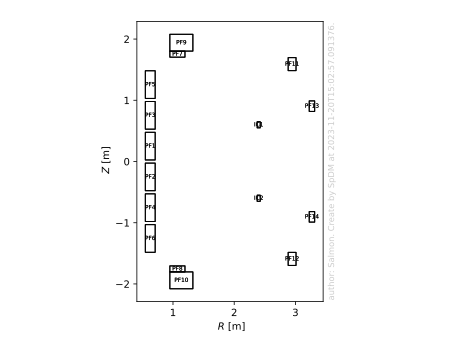

In [7]:
tok.pf_active

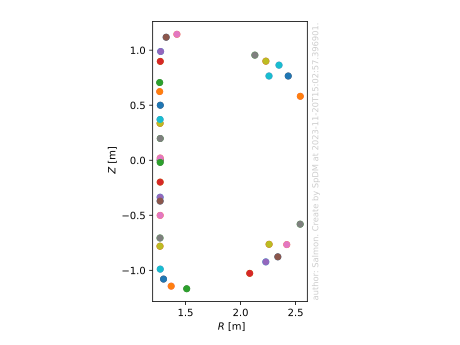

In [8]:
tok.magnetics

RuntimeError: Can not update ChainMap({'id': 'wall'}, {}) with limiter!

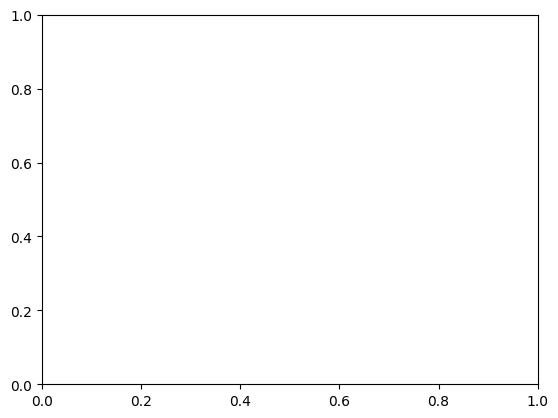

In [9]:
from spdm.view import View as sp_view

fig=sp_view.display(tok.__geometry__(view="top"))